## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from IPython.display import clear_output
from random import sample

In [ ]:
# nltk.download('punkt')

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2023-01-11 17:39:15--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2023-01-11 17:39:15 (11.5 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
text = [re.sub(r"[^а-я]", " ", string.lower()) for string in text]

text = [re.sub(r"\s+", " ", string)[:-1] for string in text if string]

text = [string+'' for string in text if string != '']

In [ ]:
text_for_token = ' '.join(text)

In [ ]:
text = [string.split(' ') for string in text]

In [ ]:
MAX_LENGTH = max(map(len, text))

In [ ]:
text

[['', 'мой', 'дядя', 'самых', 'честных', 'правил'],
 ['когда', 'не', 'в', 'шутку', 'занемог'],
 ['он', 'уважать', 'себя', 'заставил'],
 ['и', 'лучше', 'выдумать', 'не', 'мог'],
 ['его', 'пример', 'другим', 'наука'],
 ['но', 'боже', 'мой', 'какая', 'скука'],
 ['с', 'больным', 'сидеть', 'и', 'день', 'и', 'ночь'],
 ['не', 'отходя', 'ни', 'шагу', 'прочь'],
 ['какое', 'низкое', 'коварство'],
 ['полуживого', 'забавлять'],
 ['ему', 'подушки', 'поправлять'],
 ['печально', 'подносить', 'лекарство'],
 ['вздыхать', 'и', 'думать', 'про', 'себя'],
 ['когда', 'же', 'черт', 'возьмет', 'тебя'],
 ['так', 'думал', 'молодой', 'повеса'],
 ['летя', 'в', 'пыли', 'на', 'почтовых'],
 ['всевышней', 'волею', 'зевеса'],
 ['наследник', 'всех', 'своих', 'родных'],
 ['друзья', 'людмилы', 'и', 'руслана'],
 ['с', 'героем', 'моего', 'романа'],
 ['без', 'предисловий', 'сей', 'же', 'час'],
 ['позвольте', 'познакомить', 'вас'],
 ['онегин', 'добрый', 'мой', 'приятель'],
 ['родился', 'на', 'брегах', 'невы'],
 ['где', 'може

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokens = word_tokenize(text_for_token)

In [ ]:
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [ ]:
token_to_idx['\n'] = max(token_to_idx.values()) + 1
idx_to_token[max(idx_to_token.keys()) + 1] = '\n'


token_to_idx[''] = max(token_to_idx.values()) + 1
idx_to_token[max(idx_to_token.keys()) + 1] = ''

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_idx[''], dtype='int32', batch_first = True):
  
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
print(text[:5])
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix)

[['', 'мой', 'дядя', 'самых', 'честных', 'правил'], ['когда', 'не', 'в', 'шутку', 'занемог'], ['он', 'уважать', 'себя', 'заставил'], ['и', 'лучше', 'выдумать', 'не', 'мог'], ['его', 'пример', 'другим', 'наука']]
tensor([[22447, 22320,  2656,  4656,     3,  4008],
        [21994, 22431, 22383,     8,     9, 22447],
        [22194,  9152, 17170,    13, 22447, 22447],
        [22435, 21838,    16, 22431, 22305, 22447],
        [21774,    20,  8475,   450, 22447, 22447]])


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
num_tokens = max(idx_to_token.keys()) + 1

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=MAX_LENGTH, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_0):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_n = self.rnn(self.emb(x), h_0)        
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return h_n, next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()

history = []

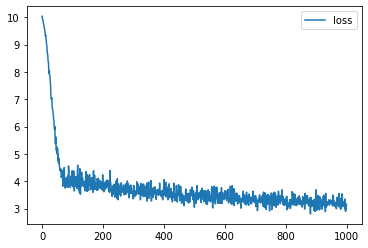

In [ ]:
for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_0 = model.initial_state(batch_size = 32)
    
    _, logp_seq = model(batch_ix, h_0)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
def generate_sample(model, seed_phrase=['мой'], max_length=MAX_LENGTH, temperature=1.0):
  
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, :,i], hid_state)
 
    for i in range(max_length - len(seed_phrase)):
        if x_sequence[:, :,-1] == torch.tensor([[[22446]]]):
            hid_state, out = model(x_sequence[:, :,-2], hid_state)
        else:
            hid_state, out = model(x_sequence[:, :,-1], hid_state)
        
        
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
      
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        if next_ix == torch.tensor([[[22447]]]):
            next_ix = torch.tensor([[[22446]]])
            hid_state = model.initial_state(batch_size=1)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    x_sequence = torch.flatten(x_sequence)
    
    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.numpy()])

In [ ]:
for _ in range(1):
    print(generate_sample(model, max_length=200, seed_phrase=['мой','дядя']))

мой дядя на это 
 шагов 
 скрыпок рюмок 
 шевелит в ты он 
 оды были 
 прелести приятно б за 
 собой и подводит зиму 
 досада слегка 
 для суждений был 
 удалая не часто 
 нелюдим воспаленном мой 
 жмет услуги 
 волновали 
 перед проворно 
 утром рожден упрочен 
 по шалунью я 
 страны посланье скучно 
 выросла позлословить управлять свет 
 в 
 надоел дам ни брег 
 рощи вернее 
 ног барин в чем 
 ль одно ленский кроме 
 и но 
 танцевал на не о 
 решена знаешь мнете 
 под тень чему 
 пробили не ленский ты свиданья выше 
 юный быстрый 
 слышу ней развлекло 
 водой утомленный 
 на ней в она слезах 
 закрывает живой муза 
 встречает поскорей 
 облокотясь лая 
 он 
 рыжем бедная со 
 нынче ли похвальной а 
 играет ни очах 
 торжествовали 
 какую лень 
 может я 
 у строй 
 двора всей 
 ты ней тишком память 
 е санях 
 шумят слышит и вздохов 
 строф человека грозно 
 день без бури 
 вс не глухой 
 другим и и детей 
 весна он хладнокровный 



### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
num_tokens = max(idx_to_token.keys()) + 1

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=MAX_LENGTH, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_0, c_0):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h = self.lstm(self.emb(x), (h_0,c_0))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return h[0], h[1], next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)

In [ ]:
model2 = CharLSTMLoop()
opt = torch.optim.Adam(model2.parameters())
criterion = nn.NLLLoss()

history = []

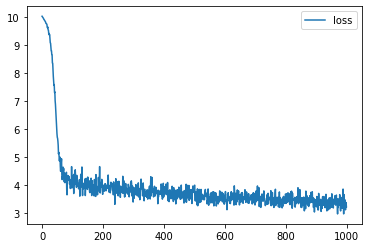

In [ ]:
for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_0 = model2.initial_state(batch_size = 32)
    hn, cn, logp_seq = model2(batch_ix, h_0, h_0)
    
    predictions_logp = logp_seq[:, :-1]    
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_sample_lstm(model, seed_phrase=['мой'], max_length=MAX_LENGTH, temperature=1.0):
  
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    cn = model.initial_state(batch_size=1)
    
    
    for i in range(len(seed_phrase) - 1):
        hid_state, cn, out = model(x_sequence[:, :,i], hid_state, cn)
    
    
    for _ in range(max_length - len(seed_phrase)):
        if x_sequence[:, :,-1] == torch.tensor([[[22446]]]):
            hid_state, cn, out = model(x_sequence[:, :,-2], hid_state, cn)
        else:
            hid_state, cn, out = model(x_sequence[:, :,-1], hid_state, cn)
       
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
     
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        if next_ix == torch.tensor([[[22447]]]):
            next_ix = torch.tensor([[[22446]]])
            hid_state = model.initial_state(batch_size=1)  
            cn = model.initial_state(batch_size=1)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
        
    x_sequence = torch.flatten(x_sequence)
    
        
    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.numpy()])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
for _ in range(1):
    print(generate_sample_lstm(model2, seed_phrase=['сон'], max_length = 50, temperature = 1))

сон мечтой душе 
 читал напрасно лапкой 
 городах в моды камельку 
 буянов детстве свои 
 смиренный верной 
 отцу пред прозы 
 вслед звон как во 
 быть не сне 
 песнях кресельных без воли 
 луне сердцам 
 так 
 годов нибудь глух безнравственной 
 выпивал нет


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
Examples are available here. - page 404 - i dont no too

TypeError: ignored

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)